In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dir_img = './tgs_salt_identification_challenge/train/images'
dir_mask = './tgs_salt_identification_challenge/train/masks'
dir_checkpoint='./tgs_salt_identification_challenge/checkpoints'
ids = [os.path.splitext(f)[0] for f in os.listdir(dir_img)]

### visualize the images and corresponding masks

In [3]:
def load_image_mask(idx):
    def transform(img, resize=True, W=None, H=None):
        # resize
        if resize:
            img = cv2.resize(img, (W, H))
        # scale down
        img = img / 255
        return img
    
    img_file = os.path.join(dir_img, idx+'.png')
    mask_file = os.path.join(dir_mask, idx+'.png')
    img = cv2.imread(img_file, 0)  # input image is in grayscale
    mask = cv2.imread(mask_file, 0)

    img = transform(img, True, 128, 128)
    mask = transform(mask, True, 128, 128)

    return img, mask

057eae4f34


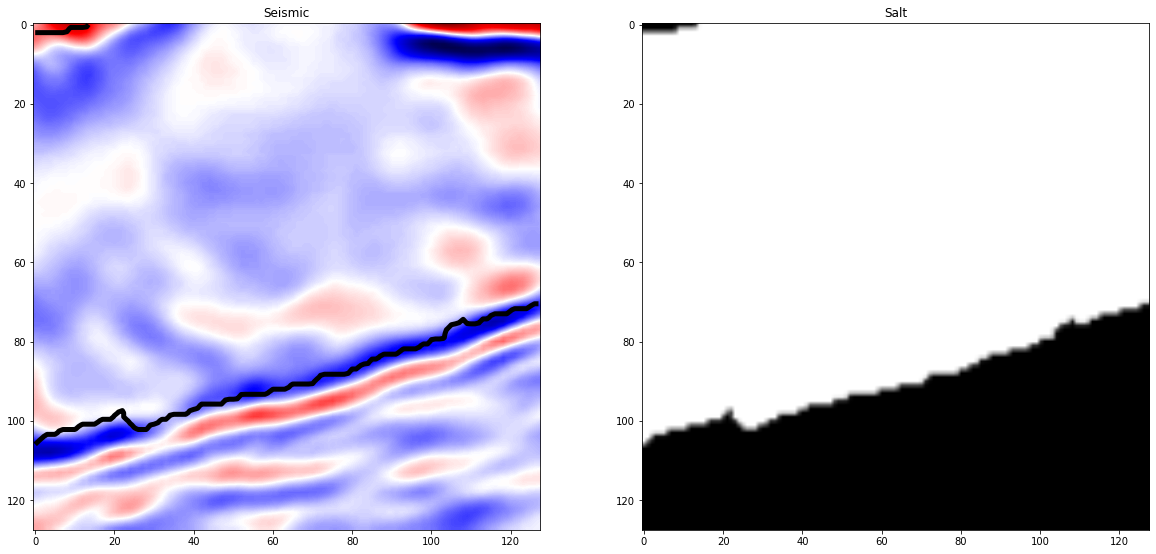

In [5]:
# Visualize any randome image along with the mask
i = random.randint(0, len(ids))
idx = ids[i]
img, mask = load_image_mask(idx)

has_mask = mask.max() > 0 # salt indicator

if has_mask: # if salt
    print(idx)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

    ax1.imshow(img, cmap='seismic', interpolation='bilinear')
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(mask, colors='k', linewidths=5, levels=[0.5])
    ax1.set_title('Seismic')

    ax2.imshow(mask, cmap='gray', interpolation='bilinear')
    ax2.set_title('Salt')

### test prediction

In [3]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from random import randint
from data import BasicDataset
from unet import UNet
from predict import load_model, predict

In [4]:
checkpoint = 44
model = load_model(dir_checkpoint, checkpoint)

In [5]:
# ids = [os.path.splitext(f)[0] for f in os.listdir(dir_img)]
# i = randint(0, len(ids))
# idx = ids[i]
idx = '057eae4f34'
img_file = os.path.join(dir_img, idx+'.png')
mask_file = os.path.join(dir_mask, idx+'.png')
img = cv2.imread(img_file, 0)  # input image is in grayscale
mask = cv2.imread(mask_file, 0)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model.to(device=device)
model.eval()

UNet(
  (dc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

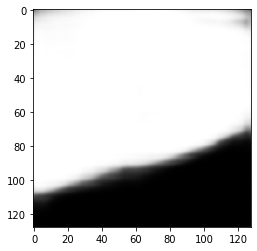

In [8]:
mask_pred = predict(model, img, device)
plt.imshow(mask_pred, cmap='gray', interpolation='bilinear')

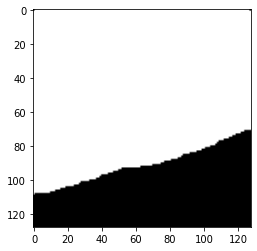

In [11]:
mask_pred_b = mask_pred > 0.5
plt.imshow(mask_pred_b, cmap='gray', interpolation='bilinear')

In [14]:
def plot_sample(img, mask, mask_pred, mask_pred_b):
    """Function to plot the results"""
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(img, cmap='seismic')
    ax[0].contour(mask, colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Salt')

    ax[2].imshow(mask_pred, cmap='gray', vmin=0, vmax=1)
    ax[2].contour(mask, colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(mask_pred_b, cmap='gray', vmin=0, vmax=1)
    ax[3].contour(mask, colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

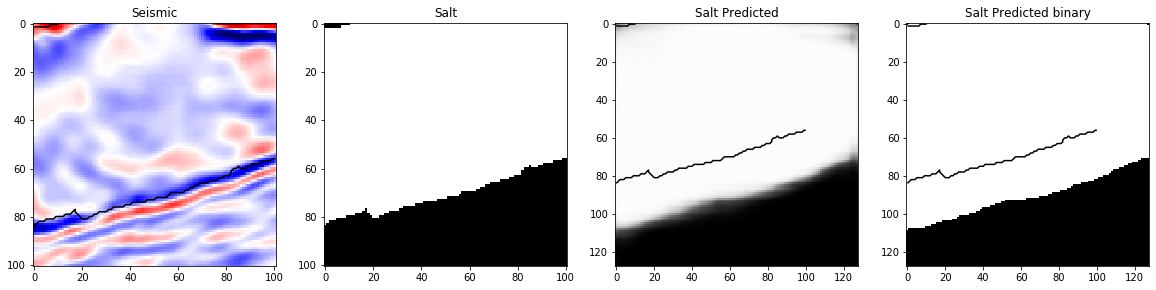

In [15]:
plot_sample(img, mask, mask_pred, mask_pred_b)